In [1]:
import os
import numpy as np
import pandas as pd

# Importing and preparing data

In [6]:
# Directory where the split files are stored
data_directory = 'Data'

# List to store each DataFrame
dataframes = []

# Read each file into a DataFrame and append to the list
for part in range(1, 11):
    file_name = f'Fireline_5mPoints_part_{part}.csv'
    file_path = os.path.join(data_directory, file_name)
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        dataframes.append(df)
    else:
        print(f'File not found: {file_path}')

# Combine all the DataFrames into a single DataFrame
combined_df = pd.concat(dataframes, ignore_index=True)

In [7]:
combined_df.columns.values

array(['FeatureCategory', 'FirelineCatPrioritizationAsgn',
       'FirelineEngagement', 'Date', 'men_sh', 'menwinddir', 'men_vpd',
       'precip', 'menburnidx', 'men_erc', 'menwindspd', 'Slope', 'Aspect',
       'RctMchTreatmt', 'HistMchTreatmt', 'PirorFireHistSev',
       'PirorFireRcntSev', 'LC22_EVC_220', 'LC22_EVH_220', 'LC22_EVT_220',
       'EVC_CLASSNAMES', 'EVH_CLASSNAMES', 'EVT_FUEL_N', 'DropArea',
       'EVC Percentage', 'Height_Meters'], dtype=object)

In [8]:
# Convert the 'Date' column to datetime
combined_df['Date'] = pd.to_datetime(combined_df['Date'])

# Find the earliest date to use as a reference
reference_date = combined_df['Date'].min()

# Calculate 'Days_elapsed' from the reference date
combined_df['Days_elapsed'] = (combined_df['Date'] - reference_date).dt.days

# Filling nan with 0
combined_df['PirorFireRcntSev'] = combined_df['PirorFireRcntSev'].fillna(0)
combined_df['PirorFireHistSev'] = combined_df['PirorFireHistSev'].fillna(0)
combined_df['DropArea'] = combined_df['DropArea'].fillna(0)

# Removing high wind points
print(len(combined_df))
combined_df = combined_df[combined_df['menwindspd'] < 35]
print(len(combined_df))

# Changing Y to numerical
combined_df['FirelineEngagement'] = combined_df['FirelineEngagement'].replace({'Not Held': 0, 'Held': 100})

# Display the DataFrame to verify the results
combined_df.head()

693453
421879


,FeatureCategory,FirelineCatPrioritizationAsgn,FirelineEngagement,Date,men_sh,menwinddir,men_vpd,precip,menburnidx,men_erc,...,LC22_EVC_220,LC22_EVH_220,LC22_EVT_220,EVC_CLASSNAMES,EVH_CLASSNAMES,EVT_FUEL_N,DropArea,EVC Percentage,Height_Meters,Days_elapsed
0,Completed Dozer Line,2,100,2021-09-02,186.0,274.0,165.0,0.0,70.0,95.0,...,130,113,7031,Tree Cover = 30%,Tree Height = 13 meters,Tr California Montane Jeffrey Pine(-Ponderosa ...,0.0,30,13.0,53
1,Completed Dozer Line,2,100,2021-09-02,186.0,274.0,165.0,0.0,70.0,95.0,...,130,113,7031,Tree Cover = 30%,Tree Height = 13 meters,Tr California Montane Jeffrey Pine(-Ponderosa ...,0.0,30,13.0,53
2,Completed Dozer Line,2,100,2021-09-02,186.0,274.0,165.0,0.0,70.0,95.0,...,130,113,7031,Tree Cover = 30%,Tree Height = 13 meters,Tr California Montane Jeffrey Pine(-Ponderosa ...,0.0,30,13.0,53
3,Completed Dozer Line,2,100,2021-09-02,186.0,274.0,165.0,0.0,70.0,95.0,...,130,113,7031,Tree Cover = 30%,Tree Height = 13 meters,Tr California Montane Jeffrey Pine(-Ponderosa ...,0.0,30,13.0,53
4,Completed Dozer Line,2,100,2021-09-02,186.0,274.0,165.0,0.0,70.0,95.0,...,130,113,7031,Tree Cover = 30%,Tree Height = 13 meters,Tr California Montane Jeffrey Pine(-Ponderosa ...,0.0,30,13.0,53


In [24]:
# Skipping EVT_FUEL_N

# Checking for highly correlated variables

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

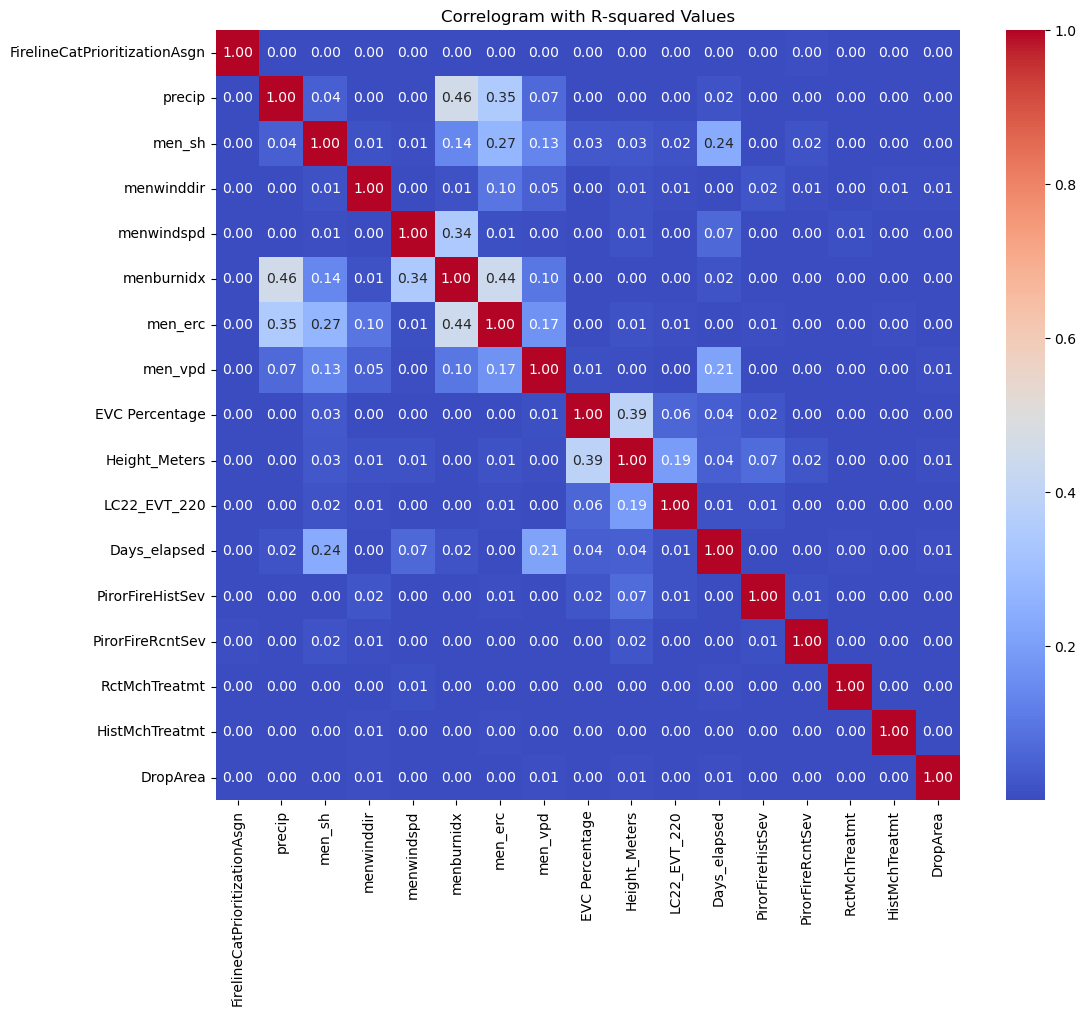

In [10]:
# Assuming combined_df is your DataFrame and it contains the specified variables
X = combined_df[['FirelineCatPrioritizationAsgn', 'precip', 'men_sh', 'menwinddir', 'menwindspd',
                 'menburnidx', 'men_erc', 'men_vpd', 'EVC Percentage', 'Height_Meters',
                 'LC22_EVT_220', 'Days_elapsed', 'PirorFireHistSev', 'PirorFireRcntSev', 'RctMchTreatmt', 'HistMchTreatmt','DropArea']]

# Calculate pairwise Pearson correlations
corr = X.corr()

# Square the correlation coefficients to get R-squared values
r_squared = corr**2

# Create a heatmap to visualize the correlations
plt.figure(figsize=(12, 10))
sns.heatmap(r_squared, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title("Correlogram with R-squared Values")
plt.show()

# Running random forests

In [13]:
import time
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.inspection import partial_dependence

In [11]:
X = combined_df[['FirelineCatPrioritizationAsgn', 'precip', 'men_sh', 'menwinddir', 'menwindspd',
                 'menburnidx', 'men_erc', 'men_vpd', 'EVC Percentage', 'Height_Meters',
                 'LC22_EVT_220', 'Days_elapsed', 'PirorFireHistSev', 'PirorFireRcntSev','RctMchTreatmt', 'HistMchTreatmt', 'DropArea']]
Y = combined_df['FirelineEngagement']

In [14]:
# Hyperparameters for grid search
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    # Add more parameters as required
}

accuracy_scores = []
f1_scores = []
feature_importances = []
last_X_test = None
last_model = None

# Create a random split for each iteration
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)  # 70% training and 30% testing

# Start timer for this iteration
start_time = time.time()

# Grid search with cross-validation
grid_search = GridSearchCV(RandomForestClassifier(random_state=0), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, Y_train)

# Time elapsed
elapsed_time = time.time() - start_time

# Best model
best_model = grid_search.best_estimator_

# Predict and evaluate
Y_pred = best_model.predict(X_test)
acc_score = accuracy_score(Y_test, Y_pred)
print(f'Accuracy: {acc_score:.4f}, Time elapsed: {elapsed_time:.2f} seconds')
f1_score = f1_score(Y_test, Y_pred, average='weighted')

# Aggregate feature importances
feature_importances = best_model.feature_importances_

# Store last model and X_test
X_test = X_test
model = best_model

Accuracy: 0.9031, Time elapsed: 466.47 seconds


In [15]:
print("Accuracy:", acc_score)
print("F1 Score:", f1_score)

Accuracy: 0.9031320122625707
F1 Score: 0.9016671872448029


In [16]:
# Assuming 'feature_importances' contains the importances from the best_model 
# and 'X' is your DataFrame with the feature names as columns
feature_names = X.columns
importances = best_model.feature_importances_

# Pairing feature names with their importances
feature_importance_pairs = zip(feature_names, importances)

# Sorting the features by importance
sorted_feature_importances = sorted(feature_importance_pairs, key=lambda x: x[1], reverse=True)

# Printing the feature importances
print("Feature Importances:")
for feature, importance in sorted_feature_importances:
    print(f"{feature}: {importance:.4f}")

Feature Importances:
EVC Percentage: 0.1152
men_vpd: 0.1103
Height_Meters: 0.1019
men_sh: 0.0973
Days_elapsed: 0.0782
LC22_EVT_220: 0.0773
menwinddir: 0.0739
men_erc: 0.0718
menburnidx: 0.0715
FirelineCatPrioritizationAsgn: 0.0594
menwindspd: 0.0515
DropArea: 0.0354
PirorFireHistSev: 0.0229
PirorFireRcntSev: 0.0186
RctMchTreatmt: 0.0071
HistMchTreatmt: 0.0068
precip: 0.0011


In [17]:
import pickle

In [18]:
def save_results(results, results_folder='../Results', file_name='random_forest_results.pkl'):
    # Create the Results directory if it doesn't exist
    if not os.path.exists(results_folder):
        os.makedirs(results_folder)

    # Save the results using pickle
    with open(os.path.join(results_folder, file_name), 'wb') as file:
        pickle.dump(results, file)

    print(f"Results saved in {os.path.join(results_folder, file_name)}")

In [19]:
# Prepare results to save
results = {
    'accuracy': acc_score,
    'f1': f1_score,
    'feature_importances': feature_importances,
    'model': model,
    'X_test': X_test
}

# Save the results
save_results(results)

Results saved in ../Results/random_forest_results.pkl


# Plotting results

In [20]:
import pickle

In [21]:
def load_results(file_path):
    with open(file_path, 'rb') as file:
        return pickle.load(file)

loaded_results = load_results('../Results/random_forest_results.pkl')

# Accessing different components of the loaded results
acc_score = loaded_results['accuracy']
f1_score = loaded_results['f1']
feature_importances = loaded_results['feature_importances']
model = loaded_results['model']
X_test = loaded_results['X_test']

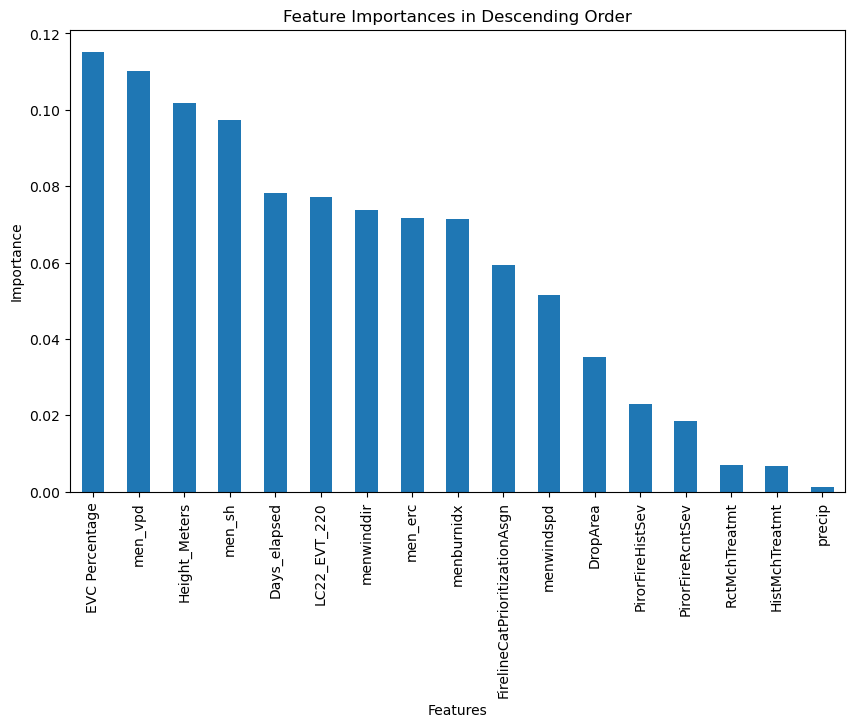

In [22]:
def plot_feature_importances(feature_importances, feature_names):
    # Create a series for easy plotting
    importances = pd.Series(feature_importances, index=feature_names)

    # Sort the feature importances in descending order
    sorted_importances = importances.sort_values(ascending=False)

    # Plot
    plt.figure(figsize=(10, 6))
    sorted_importances.plot(kind='bar')
    plt.title('Feature Importances in Descending Order')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.show()

# Feature names from your DataFrame
feature_names = X.columns  # Assuming X is your DataFrame of features

# Plot the feature importances
plot_feature_importances(feature_importances, feature_names)

In [26]:
X = combined_df[['FirelineCatPrioritizationAsgn', 'precip', 'men_sh', 'menwinddir', 'menwindspd',
                 'menburnidx', 'men_erc', 'men_vpd', 'EVC Percentage', 'Height_Meters',
                 'LC22_EVT_220', 'Days_elapsed', 'PirorFireHistSev', 'PirorFireRcntSev','RctMchTreatmt', 'HistMchTreatmt', 'DropArea']]
Y = combined_df['FirelineEngagement']

In [27]:
set(Y)

{0, 100}

Given the classification where 0 represents 'Not Held' and 100 represents 'Held', the interpretation of a Partial Dependence Plot (PDP) would be as follows:

- PDP Y-Axis Scale: The y-axis of the PDP, which ranges from 0 to 100 in this case, reflects the predicted likelihood of the 'Held' outcome according to your model. A value of 0 indicates a prediction leaning entirely towards 'Not Held', while a value of 100 indicates a prediction entirely towards 'Held'.

- Interpreting the Trend: If the PDP shows a trend where the predicted value increases from 55 to 66 for a specific feature, this indicates that as the value of this feature increases, the model's predicted likelihood of the outcome being 'Held' also increases. The shift from 55 to 66 suggests an 11-point increase on your 0-100 scale.

- Percentage Interpretation: In this context, an increase from 55 to 66 can indeed be interpreted as an 11% increase in the predicted likelihood of 'Held'. This is because your scale directly translates to percentage likelihoods, with 100 representing a 100% likelihood of being 'Held'.

- Model Dependence and Feature Influence: This interpretation is based on the average effect of the specific feature on the predicted outcome, assuming other features are held constant. It's important to consider this in the context of how the model was trained and the characteristics of your data.

- Contextual Relevance: The actual implication of this change depends on the nature of the feature being analyzed and the specific domain of this study. For example, in an ecological or environmental model, a change in a certain environmental parameter might have different implications than a change in a socio-economic factor.

In summary, in this scenario, a positive trend in the PDP from 55 to 66 for a particular feature implies that increasing the value of this feature is associated with an 11% increase in the likelihood of the outcome being classified as 'Held'.

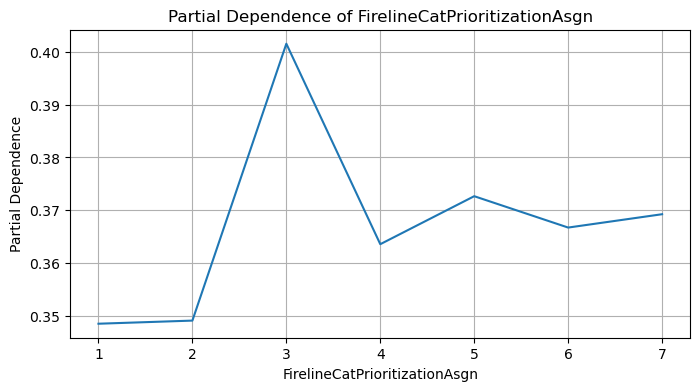

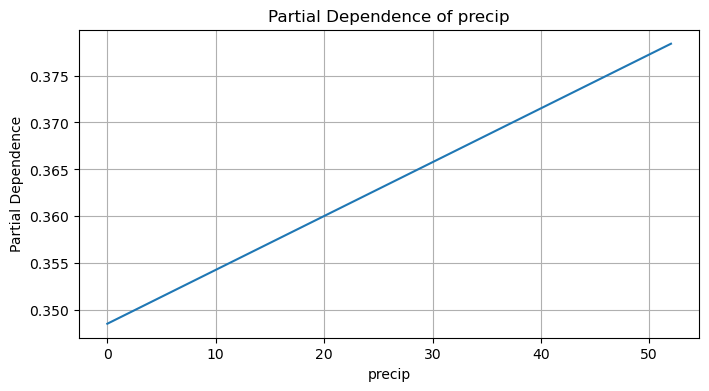

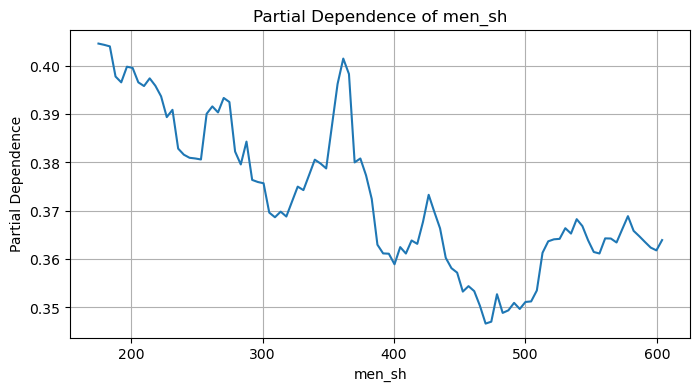

In [ ]:
def plot_pdp(model, X, feature_names):
    for feature_name in feature_names:
        # Get the partial dependence data
        pdp_result = partial_dependence(model, X, features=[feature_name])
        
        # Extract the pdp values and corresponding axes values
        pdp_values = pdp_result['average'][0]
        axes_values = pdp_result['grid_values'][0]

        # Plotting
        plt.figure(figsize=(8, 4))
        plt.plot(axes_values, pdp_values)
        plt.title(f"Partial Dependence of {feature_name}")
        plt.xlabel(feature_name)
        plt.ylabel('Partial Dependence')
        plt.grid(True)
        plt.show()

# List of feature names for PDPs
feature_names = X.columns  # Column names for labeling

# Generate PDPs
plot_pdp(model, X, feature_names)